# Статистический анализ данных
Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 

Сервисом можно пользоваться с подпиской и без нее.

Без подписки:
1. абонентская плата отсутствует;
2. стоимость одной минуты поездки —8 рублей;
3. стоимость старта (начала поездки) —  50 рублей;

С подпиской Ultra:
1. абонентская плата — 199 рублей в месяц;
2. стоимость одной минуты поездки — 6 рублей;
3. стоимость старта — бесплатно.

**Описание данных** 

Пользователи — "users_go.csv":

* "user_id" — уникальный идентификатор пользователя;
* "name" — имя пользователя;
* "age" — возраст;
* "city" — город;
* "subscription_type" — тип подписки (free, ultra).

Поездки — "rides_go.csv":

* "user_id" — уникальный идентификатор пользователя;
* "distance" — расстояние, которое пользователь проехал в текущей сессии (в метрах);
* "duration" — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»;
* "date" — дата совершения поездки.

Подписки — "subscriptions_go.csv":

* "subscription_type" — тип подписки;
* "minute_price" — стоимость одной минуты поездки по данной подписке;
* "start_ride_price" — стоимость начала поездки;
* "subscription_fee" — стоимость ежемесячного платёж.

**План работы:**
1. Загрузка библиотек и данных.
2. Предобработка данных.
3. Иследовательский анализ данных.
4. Объединение данных.
5. Подсчет выручки.
6. Проверка гипотез.
7. Выводы проекта.

### Загрузка библиотек и данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import copy
import numpy as np
from scipy import stats as st

In [2]:
users = pd.read_csv(r'~/users_go.csv')
rides = pd.read_csv(r'~/rides_go.csv')
subscriptions = pd.read_csv(r'~/subscriptions_go.csv')

Посмотрим основную информацию про пользователей

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 412.6 KB
None

           user_id          age
count  1565.000000  1565.000000
mean    762.633866    24.922045
std     443.260155     4.553496
min       1.000000    12.000000
25%     378.000000    22.000000
50%     762.000000    25.000000
75%    1146.000000    28.000000
max    1534.000000    43.000000


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


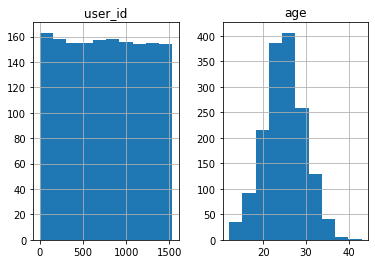

In [3]:
# Изучение датафрейма 'users' 
print(users.info(memory_usage='deep')) 
print()
print(users.describe())
users.hist()
users.head(20)

Датафрейм users имеет 5 колонок и 1565 строк, пропуски и выбросы отсутсвуют. Некоторые столбцы имеют неоптимальный тип данных, их корректировка может снизить вес датафрейма. Названия столбцов соответствуют ‘змеиному’ стилю. Присутствуют дубликаты в столбце user_id. 

In [4]:
# Уникальные названия населенных пунктов
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

Неявные дубликаты в столбце ‘city’ не обнаружены.

In [6]:
# Уникальные типы
users['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

Имеющиеся значения в столбце ‘subscription_type’ позволяют изменить ‘ultra’ и ‘free’ на True и False соответственно, а также использовать для этого столбца тип данных ‘bool’.

Посмотрим основную информацию про поездки пользователей.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None

            user_id      distance      duration
count  18068.000000  18068.000000  18068.000000
mean     842.869936   3070.659976     17.805011
std      434.734317   1116.831209      6.091051
min        1.000000      0.855683      0.500000
25%      487.000000   2543.226360     13.597563
50%      889.000000   3133.609994     17.678395
75%     1213.250000   3776.222735     21.724800
max     1534.000000   7211.007745     40.823963


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


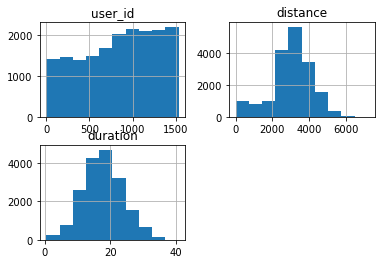

In [8]:
# Изучение датафрейма rides 
print(rides.info())
print()
print(rides.describe())
rides.hist() 
rides.head()

В датафрейме rides 4 колонки и 18068 строк. Пропущенных значений нет. Неоптимальные типы данных у 'user_id' и 'date'. Названия столбцов соответствуют ‘змеиному’ стилю. Возможно наличие выбросов в столбцах 'distance' и 'duration'.

Посмотрим основную информацию о подписках.

In [10]:
# Изучение датафрейма 'subscriptions' 
print(subscriptions.info())
subscriptions.head(20) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
None


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


В датафрейме subscriptions 4 столбца и 2 строки без пропусков и выбросов. Неоптимальные типы данных во всех столбцах. Это не является критичным при весе датафрейма в 192 байта. Названия столбцов соответствуют ‘змеиному’ стилю.

### Предобработка данных

##### Корректировка типов данных столбцов

In [11]:
# Корректировка столбцов в 'users'
users['user_id'] = users['user_id'].astype('uint16')
users['age'] = users['age'].astype('uint8')
users.loc[users['subscription_type'] == 'ultra', 'subscription_type'] = True # 'ultra'
users.loc[users['subscription_type'] == 'free', 'subscription_type'] = False # 'free'
users['subscription_type'] = users['subscription_type'].astype('bool')

In [12]:
# Корректировка столбца 'date' в датафейме 'rides'
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides['user_id'] = rides['user_id'].astype('uint16')

In [13]:
# Корректировка столбца 'subscription_type' в датафейме 'subscriptions_go'
subscriptions.loc[subscriptions['subscription_type'] == 'ultra', 'subscription_type'] = True # 'ultra'
subscriptions.loc[subscriptions['subscription_type'] == 'free', 'subscription_type'] = False # 'free'
subscriptions['subscription_type'] = subscriptions['subscription_type'].astype('bool')
for i in ['minute_price', 'start_ride_price', 'subscription_fee']:
    subscriptions[i] = subscriptions[i].astype('uint8')

##### Добавление столбца с номером месяца на основе столбца date.

In [14]:
rides['month_number'] = rides['date'].dt.month
##### Корректировка типа данных
rides['month_number'] = rides['month_number'].astype('uint8')

In [15]:
min_date = rides['date'].min()
max_date = rides['date'].max()
print(f'Период значений столбца date от {min_date} до {max_date}')

Период значений столбца date от 2021-01-01 00:00:00 до 2021-12-30 00:00:00


##### Обработка неявных дубликатов.

In [16]:
# Удаление дубликатов идентификаторов в столбце 'user_id' датафрейма 'users'
users = users.sort_values(by='user_id').loc[users['user_id'].duplicated() == False]

In [17]:
# Проверка наличия дубликатов в users
users.sort_values(by='user_id').loc[users['user_id'].duplicated () == True].count()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Дубликаты удалены из 'user_id' датафрейма user.

Проверка результатов предобработка данных.

In [18]:
# Датафейм 'users'
users.info(memory_usage='deep')
users.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   uint16
 1   name               1534 non-null   object
 2   age                1534 non-null   uint8 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   bool  
dtypes: bool(1), object(2), uint16(1), uint8(1)
memory usage: 331.8 KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,True
1,2,Станислав,31,Омск,True
2,3,Алексей,20,Москва,True
3,4,Константин,26,Ростов-на-Дону,True
4,5,Адель,28,Омск,True


Итак, мы обработали дубликаты, сократили количество строк с 1565 до 1534, вес датафрейма уменьшился почти с 412.6 Кб до 306.2 Кб.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       18068 non-null  uint16        
 1   distance      18068 non-null  float64       
 2   duration      18068 non-null  float64       
 3   date          18068 non-null  datetime64[ns]
 4   month_number  18068 non-null  uint8         
dtypes: datetime64[ns](1), float64(2), uint16(1), uint8(1)
memory usage: 476.5 KB
None

            user_id      distance      duration  month_number
count  18068.000000  18068.000000  18068.000000  18068.000000
mean     842.869936   3070.659976     17.805011      6.486772
std      434.734317   1116.831209      6.091051      3.437410
min        1.000000      0.855683      0.500000      1.000000
25%      487.000000   2543.226360     13.597563      4.000000
50%      889.000000   3133.609994     17.678395      6.000000
75%     1213.250000 

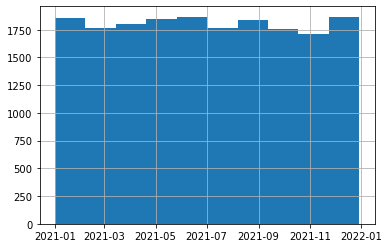

In [19]:
#датафрейм rides 
print(rides.info())
print()
print(rides.describe())
print('Минимальная дата :', min_date)
print('Максимальная дата:', max_date)
rides['date'].hist()
plt.show()

В процессе предобработки данных в датафрейме rides был добавлен столбец 'month_number' и изменены типы данных столбцов. Также проверены данные в столбце с датами. Диапазон дат с 01.01.2021 по 30.12.2021. В пределах этого диапазона дат количество значений относительно равномерно распределено.

In [20]:
# Датафейм 'subscriptions'
subscriptions.info()
subscriptions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   subscription_type  2 non-null      bool 
 1   minute_price       2 non-null      uint8
 2   start_ride_price   2 non-null      uint8
 3   subscription_fee   2 non-null      uint8
dtypes: bool(1), uint8(3)
memory usage: 136.0 bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,False,8,50,0
1,True,6,0,199


In [21]:
# Функция для более наглядного отображения значений
# 'ultra' и 'free' в поле 'subscription_type' разных датафреймов
def subscriptions_go_translate(data):
    result = copy.deepcopy(data)
    result.loc[result['subscription_type'] == True, 'subscription_type'] = 'ultra'
    result.loc[result['subscription_type'] == False, 'subscription_type'] = 'free'
    return result

subscriptions_go_translate(subscriptions).head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Мы обработали датафреймы, удалив дубликаты и изменив типы данных. Последнее несильно повлияло на вес, но для более крупных датафреймов, думаю, это было бы очень кстати.

### Исследовательский анализ данных

In [22]:
# Группировка значений
def quality_groupby(data, column):
    if 'subscription_fee' in subscriptions.columns:
        result = subscriptions_go_translate(data).groupby([column])[column].agg(['count']).sort_values(by='count')
    else:
        result = data.groupby([column])[column].agg(['count']).sort_values(by='count')

    result['percent'] = result['count'] / result['count'].sum()
    return result

In [23]:
# Функции визуализации столбцов с качественными данными
def quality(data, column, xlabel, ylabel, title):
    print('Название столбца:', column)
    go = quality_groupby(data, column)
    go.columns = {'Количество':'count', 'Доля':'percent'}
    
    plt.barh(
        go.index, 
        go['Количество'].values
    )
    plt.gca().set(xlabel=f'${xlabel}$', ylabel=f'${ylabel}$')
    plt.title(f'{title}')
    plt.show()
    
    print('Значения датафрейма:')
    print(go)
    print('\nОписание датафрейма:')
    print(go.describe())

In [24]:
# Функция визуализации столбцов с количественными данными
def quantity(data, column, bins_num, xlabel, ylabel, title):
    print('Название столбца:', column)
    data[column].hist(bins=bins_num)
    plt.gca().set(xlabel=f'${xlabel}$', ylabel=f'${ylabel}$')
    plt.title(f'{title}')
    plt.show()
    print('Описание датафрейма:')
    print(data[column].describe().round(0))

##### Частота встречаемости городов.

Название столбца: city


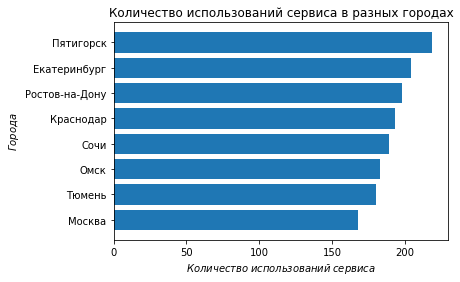

Значения датафрейма:
                Количество      Доля
city                                
Москва                 168  0.109518
Тюмень                 180  0.117340
Омск                   183  0.119296
Сочи                   189  0.123207
Краснодар              193  0.125815
Ростов-на-Дону         198  0.129074
Екатеринбург           204  0.132986
Пятигорск              219  0.142764

Описание датафрейма:
       Количество      Доля
count    8.000000  8.000000
mean   191.750000  0.125000
std     15.672998  0.010217
min    168.000000  0.109518
25%    182.250000  0.118807
50%    191.000000  0.124511
75%    199.500000  0.130052
max    219.000000  0.142764


In [25]:
quality(
    users, 
    'city', 
    'Количество_  использований_  сервиса', 
    'Города', 
    'Количество использований сервиса в разных городах'
)

Лидером по частотности является Пятигорск - 219 строк. Далее Екатеринбург - 204 строки. И последним входит в тройку - Ростов-на-Дону - 198 строк. Наименьшее количество в Москве - 168. 

##### Соотношение пользователей с подпиской и без подписки.

Название столбца: subscription_type
Значения датафрейма:

                   Количество      Доля
subscription_type                      
ultra                     699  0.455671
free                      835  0.544329

Описание датафрейма:
       Количество      Доля
count    2.000000  2.000000
mean   767.000000  0.500000
std     96.166522  0.062690
min    699.000000  0.455671
25%    733.000000  0.477836
50%    767.000000  0.500000
75%    801.000000  0.522164
max    835.000000  0.544329


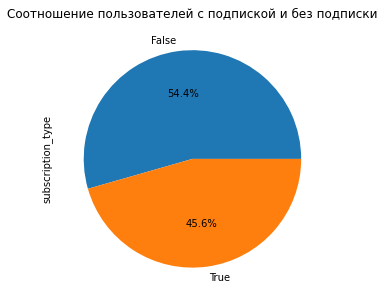

In [26]:
print('Название столбца:', 'subscription_type')
go = quality_groupby(users, 'subscription_type')
go.columns = {'Количество':'count', 'Доля':'percent'}

    
print('Значения датафрейма:')
print()
print(go)
print('\nОписание датафрейма:')
print(go.describe())

users['subscription_type'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(5, 5))
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.show()

Пользователей с подпиской «free» всего 835, что составляет 54.43% от общего количества и на 136 больше, чем с подпиской «ultra»

##### Возраст пользователей.

Название столбца: age


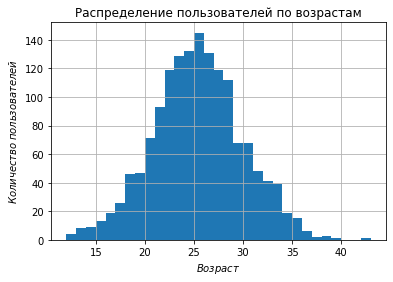

Описание датафрейма:
count    1534.0
mean       25.0
std         5.0
min        12.0
25%        22.0
50%        25.0
75%        28.0
max        43.0
Name: age, dtype: float64


In [27]:
quantity(
    users, 
    'age', 
    users['age'].max()-users['age'].min(), 
    'Возраст', 
    'Количество_ пользователей',
    'Распределение пользователей по возрастам' 
)

Услугами сервиса аренды самокатов GoFast пользуются люди с 12 лет до 43. Распределение возрастной кривой имеет нормальное распределние. Медианой здесь является возраст 25 лет, как и максимальное количество пользователей этого возраста.

##### Расстояние, которое пользователь преодолел за одну поездку.

Название столбца: distance


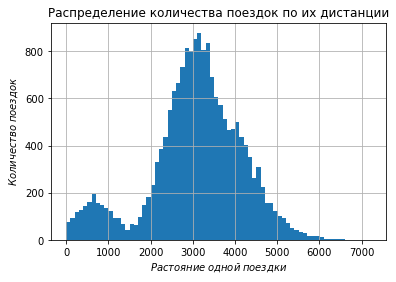

Описание датафрейма:
count    18068.0
mean      3071.0
std       1117.0
min          1.0
25%       2543.0
50%       3134.0
75%       3776.0
max       7211.0
Name: distance, dtype: float64


In [28]:
quantity(
    rides, 
    'distance', 
     int((rides['distance'].max()-rides['distance'].min()) / 100), 
    'Растояние_ одной_ поездки', 
    'Количество_ поездок',
    'Распределение количества поездок по их дистанции' 
)

Кривая графика нормально распределена, за исключением двух пиков в точках 700 метров и 3200. Медиана - 3134 метра. Пользователи преодолевают расстояния от 1 до 7211 метров.

##### Продолжительность поездок.

Название столбца: duration


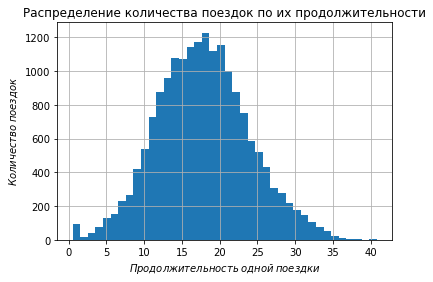

Описание датафрейма:
count    18068.0
mean        18.0
std          6.0
min          0.0
25%         14.0
50%         18.0
75%         22.0
max         41.0
Name: duration, dtype: float64


In [29]:
quantity(
    rides, 
    'duration', 
     int((rides['duration'].max()-rides['duration'].min())), 
    'Продолжительность_ одной_ поездки', 
    'Количество_ поездок',
    'Распределение количества поездок по их продолжительности' 
)

Пользователи пользуются услугой от 0 до 41 минуты. Наше распределение кривой близко к нормальному. Наблюдается пик в 2-3 минутах. Медиана составляет 18 минут. Наблюдается аномалия размером менее 100 поездок с продолжительностью в 1 минуту. Однако, они не являются выбрасами, т.к. подкреплены данными о поездках со столь же маленькими дистанциями.

In [30]:
data = rides.loc[rides['duration'] <= 3]
data['distance'].describe()

count     128.000000
mean     3848.920522
std      2227.759209
min        11.283615
25%       464.415121
50%      4711.849594
75%      5323.937502
max      7211.007745
Name: distance, dtype: float64

### Объединение данных

##### Объединение данных о пользователях, поездках и подписках в один датафрейм методом merge().

In [31]:
total = users.merge(rides, on='user_id').merge(subscriptions, on='subscription_type')
total.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month_number,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,True,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,True,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,True,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,True,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,True,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,True,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,True,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,True,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,True,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,True,748.690645,15.041884,2021-11-22,11,6,0,199


In [32]:
total.shape [0] == rides.shape[0]

True

In [33]:
total.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month_number         0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

##### Создание двух датафрейма c данными о пользователях без подписки и с данными о пользователях с подпиской.

In [34]:
ultra = total.loc[total['subscription_type'] == True]
free = total.loc[total['subscription_type'] == False]

##### Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий.

In [36]:
def quantity_comparison(data1, data2, column, bins_num, xlabel, ylabel, title, dataname1, dataname2):
    print('Сравнение столбцов:', column)
    
    data1.rename(columns = {column:dataname1})[dataname1].plot.hist(
        bins=bins_num, 
        alpha=.5, 
        legend=True,
        grid=True
    )
    data2.rename(columns = {column:dataname2})[dataname2].plot.hist(
        bins=bins_num, 
        alpha=.5, 
        legend=True,
        grid=True
    )
    
    plt.gca().set(xlabel=f'${xlabel}$', ylabel=f'${ylabel}$')
    plt.title(f'{title}')
    plt.show()
    
    print(f"Описание датафрейма '{dataname1}':")
    print(data1[column].describe().round(0))
    
    print(f"\nОписание датафрейма '{dataname2}':")
    print(data2[column].describe().round(0))

Сравнение столбцов: distance


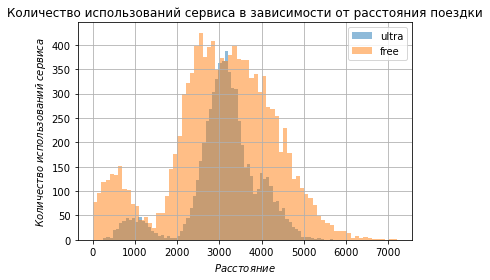

Описание датафрейма 'ultra':
count    6500.0
mean     3115.0
std       837.0
min       244.0
25%      2785.0
50%      3149.0
75%      3561.0
max      5700.0
Name: distance, dtype: float64

Описание датафрейма 'free':
count    11568.0
mean      3045.0
std       1246.0
min          1.0
25%       2367.0
50%       3115.0
75%       3906.0
max       7211.0
Name: distance, dtype: float64


In [37]:
# Срвнение столбцов 'distance' в 'ultra' и 'free'
quantity_comparison(
    ultra, 
    free, 
    'distance', 
    int(free['distance'].max()/100), 
    'Расстояние', 
    'Количество_ использований_ сервиса', 
    'Количество использований сервиса в зависимости от расстояния поездки', 
    'ultra', 
    'free'
)

Дистанции пользователей free более разнообразны: минимальное значение на 243 меньше, чем по подписке ultra; маскимальное значение больше на 1511. Об этом же свидетельствует и стандартное отклонение, которое при использовании подписки free больше на 409 метров, чем при использовании подписки ultra.

Наблюдается два пика. Если рассматривать по подписке free, то они приходятся на значения 900 и 3200. По подписке ultra: 500 и 2500-3500 метров. 

Сравнение столбцов: duration


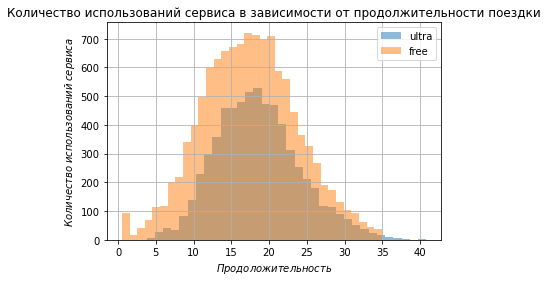

Описание датафрейма 'ultra':
count    6500.0
mean       19.0
std         6.0
min         4.0
25%        15.0
50%        18.0
75%        22.0
max        41.0
Name: duration, dtype: float64

Описание датафрейма 'free':
count    11568.0
mean        17.0
std          6.0
min          0.0
25%         13.0
50%         17.0
75%         22.0
max         35.0
Name: duration, dtype: float64


In [38]:
# Срвнение столбцов 'duration' в 'ultra' и 'free'
quantity_comparison(
    ultra, 
    free, 
    'duration', 
    int(free['duration'].max()), 
    'Продоложительность', 
    'Количество_ использований_ сервиса', 
    'Количество использований сервиса в зависимости от продолжительности поездки', 
    'ultra', 
    'free'
)

Кривые графиков имеют нормальное распределение. Пользователей с подпиской free больше, почти в два раза. Среднее значение отличается на две единицы, стандартное отклонение одинаково. Минимальное значение у free меньше, чем в ultra, на 4 единицы, максимальное значение тоже меньше на 6 единиц. Пик количества поездок приходится на 17-18 минут.

### Подсчёт выручки

Создание датафрейма с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: нахождение суммарного расстояния, количества поездок и суммарного времени для каждого пользователя за каждый месяц.

In [39]:
# Округление продолжительности поездок в 'duration'
total['duration'] = np.ceil(total['duration'])

In [40]:
# Создание сводной таблицы
users_months = total.pivot_table(
    index=('user_id', 'month_number'), 
    values=(
        'distance', 
        'duration', 
        'minute_price', 
        'start_ride_price', 
        'subscription_fee',
        'subscription_type'
    ), 
    aggfunc=('count', 'sum'))

users_months

distance               duration       minute_price      \
                        count           sum    count   sum        count sum   
user_id month_number                                                          
1       1                   2   7027.511294        2  42.0            2  12   
        4                   1    754.159807        1   7.0            1   6   
        8                   2   6723.470560        2  46.0            2  12   
        10                  2   5809.911100        2  32.0            2  12   
        11                  3   7003.499363        3  56.0            3  18   
...                       ...           ...      ...   ...          ...  ..   
1534    6                   2   3409.468534        2  26.0            2  16   
        8                   2   7622.453034        2  48.0            2  16   
        9                   1   4928.173852        1  23.0            1   8   
        11                  4  13350.015305        4  78.0            4  32   
        12                  1   2371.711192        1  16.0            1   8   

                     start_ride_price        subscription_fee         \
                                count    sum            count    sum   
user_id month_number                                                   
1       1                           2    0.0                2  398.0   
        4                           1    0.0                1  199.0   
        8                           2    0.0                2  398.0   
        10                          2    0.0                2  398.0   
        11                          3    0.0                3  597.0   
...                               ...    ...              ...    ...   
1534    6                           2  100.0                2    0.0   
        8                           2  100.0                2    0.0   
        9                           1   50.0                1    0.0   
        11                          4  200.0                4    0.0   
        12                          1   50.0                1    0.0   

                     subscription_type      
                                 count sum  
user_id month_number                        
1       1                            2   2  
        4                            1   1  
        8                            2   2  
        10                           2   2  
        11                           3   3  
...                                ...  ..  
1534    6                            2   0  
        8                            2   0  
        9                            1   0  
        11                           4   0  
        12                           1   0  

[11331 rows x 12 columns]

In [41]:
# Переименование "двухэтажных" названий столбцов
users_months.columns = [
    'count', 'distance', 
    'count2', 'duration', 
    'count3', 'minute_price',
    'count4', 'start_ride_price', 
    'count5', 'subscription_fee',
    'count6', 'subscription_type'
]

In [43]:
users_months.head(10)

count      distance  count2  duration  count3  \
user_id month_number                                                  
1       1                 2   7027.511294       2      42.0       2   
        4                 1    754.159807       1       7.0       1   
        8                 2   6723.470560       2      46.0       2   
        10                2   5809.911100       2      32.0       2   
        11                3   7003.499363       3      56.0       3   
        12                2   6751.629942       2      28.0       2   
2       3                 3  10187.723006       3      63.0       3   
        4                 2   6164.381824       2      40.0       2   
        6                 1   3255.338202       1      14.0       1   
        7                 2   6780.722964       2      48.0       2   

                      minute_price  count4  start_ride_price  count5  \
user_id month_number                                                   
1       1                       12       2               0.0       2   
        4                        6       1               0.0       1   
        8                       12       2               0.0       2   
        10                      12       2               0.0       2   
        11                      18       3               0.0       3   
        12                      12       2               0.0       2   
2       3                       18       3               0.0       3   
        4                       12       2               0.0       2   
        6                        6       1               0.0       1   
        7                       12       2               0.0       2   

                      subscription_fee  count6  subscription_type  
user_id month_number                                               
1       1                        398.0       2                  2  
        4                        199.0       1                  1  
        8                        398.0       2                  2  
        10                       398.0       2                  2  
        11                       597.0       3                  3  
        12                       398.0       2                  2  
2       3                        597.0       3                  3  
        4                        398.0       2                  2  
        6                        199.0       1                  1  
        7                        398.0       2                  2

In [44]:
users_months = users_months.drop(['count2', 'count3', 'count4', 'count5', 'count6'], axis=1)
# Приведение столбцов с ценами к целевому состоянию
users_months['start_ride_price'] = users_months['start_ride_price'] / users_months['count']
users_months['minute_price'] = users_months['minute_price'] / users_months['count']
users_months['subscription_fee'] = users_months['subscription_fee'] / users_months['count']
users_months['subscription_type'] = users_months['subscription_type'] / users_months['count']
users_months.head(10)

count      distance  duration  minute_price  \
user_id month_number                                                
1       1                 2   7027.511294      42.0           6.0   
        4                 1    754.159807       7.0           6.0   
        8                 2   6723.470560      46.0           6.0   
        10                2   5809.911100      32.0           6.0   
        11                3   7003.499363      56.0           6.0   
        12                2   6751.629942      28.0           6.0   
2       3                 3  10187.723006      63.0           6.0   
        4                 2   6164.381824      40.0           6.0   
        6                 1   3255.338202      14.0           6.0   
        7                 2   6780.722964      48.0           6.0   

                      start_ride_price  subscription_fee  subscription_type  
user_id month_number                                                         
1       1                          0.0             199.0                1.0  
        4                          0.0             199.0                1.0  
        8                          0.0             199.0                1.0  
        10                         0.0             199.0                1.0  
        11                         0.0             199.0                1.0  
        12                         0.0             199.0                1.0  
2       3                          0.0             199.0                1.0  
        4                          0.0             199.0                1.0  
        6                          0.0             199.0                1.0  
        7                          0.0             199.0                1.0

In [45]:
users_months['subscription_type'].replace(1, 'ultra', inplace=True)
users_months['subscription_type'].replace(0, 'free', inplace=True)

users_months.head(10)

count      distance  duration  minute_price  \
user_id month_number                                                
1       1                 2   7027.511294      42.0           6.0   
        4                 1    754.159807       7.0           6.0   
        8                 2   6723.470560      46.0           6.0   
        10                2   5809.911100      32.0           6.0   
        11                3   7003.499363      56.0           6.0   
        12                2   6751.629942      28.0           6.0   
2       3                 3  10187.723006      63.0           6.0   
        4                 2   6164.381824      40.0           6.0   
        6                 1   3255.338202      14.0           6.0   
        7                 2   6780.722964      48.0           6.0   

                      start_ride_price  subscription_fee subscription_type  
user_id month_number                                                        
1       1                          0.0             199.0             ultra  
        4                          0.0             199.0             ultra  
        8                          0.0             199.0             ultra  
        10                         0.0             199.0             ultra  
        11                         0.0             199.0             ultra  
        12                         0.0             199.0             ultra  
2       3                          0.0             199.0             ultra  
        4                          0.0             199.0             ultra  
        6                          0.0             199.0             ultra  
        7                          0.0             199.0             ultra

In [46]:
agg_tbl = total.groupby(['user_id', 'month_number']).agg({'subscription_type' : 'first'
                                                            , 'minute_price' : 'first'
                                                            , 'start_ride_price' : 'first'
                                                            , 'subscription_fee' : 'first'
                                                            , 'duration' : 'sum'
                                                            , 'distance' : 'sum'
                                                            , 'date' : 'count'
                                                       }
                                                      ).reset_index() # формируем сводную таблицу

agg_tbl['revenue'] = (agg_tbl['duration'] * agg_tbl['minute_price'] 
                     + agg_tbl['start_ride_price'] * agg_tbl['date'] # считаем выручку
                     + agg_tbl['subscription_fee']
                       )

display(agg_tbl.head())

,user_id,month_number,subscription_type,minute_price,start_ride_price,subscription_fee,duration,distance,date,revenue
0,1,1,True,6,0,199,42.0,7027.511294,2,451.0
1,1,4,True,6,0,199,7.0,754.159807,1,241.0
2,1,8,True,6,0,199,46.0,6723.470560,2,475.0
3,1,10,True,6,0,199,32.0,5809.911100,2,391.0
4,1,11,True,6,0,199,56.0,7003.499363,3,535.0


##### Добавление в агрегированный датафрейм столбца с помесячной выручкой, которую принёс каждый пользователь

In [47]:
users_months['revenue'] = (
    users_months['subscription_fee']
    + users_months['minute_price'] * users_months['duration'] 
    + users_months['start_ride_price'] * users_months['count']
)

users_months['revenue'] = users_months['revenue'].astype('uint16')

# Удаление столбцов со вспомогательными данными
users_months = users_months.drop(['start_ride_price', 'minute_price'], axis=1)

users_months.head(10)

count      distance  duration  subscription_fee  \
user_id month_number                                                    
1       1                 2   7027.511294      42.0             199.0   
        4                 1    754.159807       7.0             199.0   
        8                 2   6723.470560      46.0             199.0   
        10                2   5809.911100      32.0             199.0   
        11                3   7003.499363      56.0             199.0   
        12                2   6751.629942      28.0             199.0   
2       3                 3  10187.723006      63.0             199.0   
        4                 2   6164.381824      40.0             199.0   
        6                 1   3255.338202      14.0             199.0   
        7                 2   6780.722964      48.0             199.0   

                     subscription_type  revenue  
user_id month_number                             
1       1                        ultra      451  
        4                        ultra      241  
        8                        ultra      475  
        10                       ultra      391  
        11                       ultra      535  
        12                       ultra      367  
2       3                        ultra      577  
        4                        ultra      439  
        6                        ultra      283  
        7                        ultra      487

### Проверка гипотез

##### Гипотеза 1
Тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.

Нулевая и альтернативная гипотезы:

1. Гипотеза H0: пользователи с подпиской ultra и free тратят одинаковое время на поездки.
2. Гипотеза H1: пользователи с подпиской ultra тратят больше времени на поездки, чем free.

In [49]:
results = st.ttest_ind(ultra['duration'], free['duration'], equal_var=False, alternative='greater')

print(results.pvalue)

print()

print('Среднее значение с подпиской:', ultra['duration'].mean())
print('Среднее значение без подписки:', free['duration'].mean())

print()

if results.pvalue < .05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

5.6757813771289775e-37

Среднее значение с подпиской: 18.541985162805805
Среднее значение без подписки: 17.39090929866398

Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу и принимает альтернативную: среднее время поездок пользователей с подпиской больше времени поездок пользователей без подписки.

##### Гипотеза 2
Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката с подпиской. 

Нулевая и альтернативная гипотезы:

1. Гипотеза Н0: Среднее расстояние поездок с использованием подписки ultra равно оптимальному расстоянию в 3130 метров.
2. Гипотеза Н1: Среднее расстояние поездок с использованием подписки ultra больше 3130 метров.

In [50]:
results = st.ttest_1samp(ultra['distance'], 3130, alternative='greater')

print(results.pvalue)
print()
print(ultra['distance'].median())
print(ultra['distance'].mean())
print()

if results.pvalue < .05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.9195368847849785

3148.6372291760854
3115.445388037025

Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть гипотезу о том, что среднее расстояние поездок с использованием подписки ultra равно 3130 метров.

##### Гипотеза 3
Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Нулевая и альтернативная гипотезы:
1. Гипотеза Н0: Средняя выручка от поездок с разной подпиской равна.
2. Гипотеза Н1: Средняя выручка от поездок с использованием подписки ultra выше, чем выручка с ипользованием подписки free.

In [51]:
df_ultra = users_months[users_months['subscription_type'] == 'ultra']
df_free = users_months[users_months['subscription_type'] == 'free']

results = st.ttest_ind(df_ultra['revenue'], df_free['revenue'],
    equal_var=False,
    alternative='greater'
)

print()
print('Среднее значение без подписки: ', users_months.loc[users_months['subscription_type'] == 'free', 'revenue'].mean())
print('Среднее значение с подпиской: ', users_months.loc[users_months['subscription_type'] == 'ultra', 'revenue'].mean())
print()
print(results.pvalue)
print()
if results.pvalue < .05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


Среднее значение без подписки:  328.6413651073845
Среднее значение с подпиской:  362.7921906022502

8.874140893976874e-40

Отвергаем нулевую гипотезу


Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что помесячная выручка от пользователи с подпиской больше.

###### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Нулевая и альтернативная гипотезы:

Гипотеза Н0: Количество обращений в техподдержку осталось прежним.

Гипотеза Н1: Количество обращений в техподдержку снизилось.

В данном случае нужно применить тест проверки гипотез о равенстве средних для зависимых выборок метод scipy.stats.ttest_rel(before, after, alternative="greater"))

### Вывод проекта

Основная цель проекта достигнута. Проанализированы данные сервиса аренды самокатов GoFast и проверены некоторые гипотезы, которые могут помочь бизнесу вырасти.

В ходе проекта были проделаны следующие шаги:

1. Загрузка данных.
2. Предобработка данных:
* Корректировка типов данных столбцов.
* Добавление столбцов.
* Обработка неявных дубликатов.

3. Исследовательский анализ данных:
* Частота встречаемости городов.
* Соотношение пользователей с подпиской и без нее.
* Возраст пользователей.
* Расстояние, которое пользователь преодолел за одну поездку.
* Продолжительность поездок.
4. Объединение данных.
* Объединение данных о пользователях, поездках и подписках в один датафрейм методом merge().
* Создание двух датафреймов с пользователями, имеющими подписку и без нее, на основе общего датафрейма.
* Визуализация данных о расстоянии и времени поездок для пользователей обеих категорий.
5. Подсчёт выручки.
* Создание датафрейма, агрегированного по пользователям, на основе total.
* Добавление столбца в агрегированный датафрейм с помесечной выручкой по каждому пользователю
6. Проверка гипотез:
* Тратят ли пользователи с подпиской больше времени на поездки?
* Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
* Помесчячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки? 
* Каким тестом проверить гипотезу о снижении количества пользовательских обращений после обновления сервиса, с которым взаимодействует мобильное приложение?

В ходе исследовательского анализа данных было выявлено:

1. Пользователей с подпиской «free» всего 835, что составляет 54.43% от общего количества и на 136 больше, чем с подпиской «ultra».
2. Услугами сервиса аренды самокатов пользуются люди от 12 до 43 лет. Максимальное количество пользователей в возрасте 25 лет, этот же возраст является медианным.
3. Максимальное количество в 219 поездок совершено в Пятигорске. Минимальное количество в 168 поездок совершено в Москве.
4. За одну поездку пользователи преодолевают от 1 до 7211 метров. Медиана всех значений равна 3134 метров. Наблюдаются два пика. Малый пик около 700 метров, большой пик около 3200 метров. Между пиками значения нормально распределены.
5. Пользователи пользуются услугой от 0 до 41 минуты. Распределение кривой близко к нормальному. Наблюдается пик в 2-3 минутах. Медиана составляет 18 минут. Наблюдается аномалия размером менее 100 поездок с продолжительностью в 1 минуту. Однако, они не являются выбрасами, т.к. подкреплены данными о поездках со столь же маленькими дистанциями.

Проверка гипотез показала следующее:

* Среднее время поездок пользователей с подпиской больше времени поездок пользователей без подписки.
* Среднее расстояние поездок с использованием подписки ultra равно оптимальному расстоянию в 3130 метров.
* Есть основания говорить, что помесячная выручка от пользователи с подпиской больше.
* В данном примере нужно применить тест проверки гипотез о равенстве средних для зависимых выборок метод scipy.stats.ttest_rel(before, after, alternative=’less’))